# Practice: Train a Neural Network on Gaussian Quantiles

In this notebook, you'll train a neural network on the **gaussian quantiles** dataset!

**What is gaussian quantiles?** It generates nested Gaussian shells - data is drawn from a single Gaussian distribution and split into classes by quantiles. Similar to circles but with Gaussian distribution!

---

## How This Notebook Works

- **Instructions** explain what to do
- **TODO** sections are for you to fill in
- **Hints** are available if you get stuck
- **Solutions** are hidden - try first before looking!

---

## Step 1: Setup - Imports

First, let's import the libraries we need.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles

%matplotlib inline

print("Imports successful!")

Imports successful!


## Step 2: Copy Your Value Class

Copy the `Value` class from your summary notebook (003-summary_brief_of_micrograd.ipynb).

This is the foundation - we need it for automatic differentiation!

In [2]:
class Value:
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
		
	def __repr__(self):
		return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
	
	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		def _backward():
			self.grad += out.grad
			other.grad += out.grad
		out._backward = _backward
		return out
	
	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward
		return out
	
	def __pow__(self, exponent):
		assert isinstance(exponent, (int, float)), "Only supporting int/float powers for now"
		out = Value(self.data ** exponent, (self,), f'**{exponent}')
		def _backward():
			self.grad += exponent * (self.data ** (exponent - 1)) * out.grad
		out._backward = _backward
		return out
	
	def __neg__(self):
		return self * -1
	
	def __sub__(self, other):
		return self + (-other)
	
	def __truediv__(self, other):
		return self * other**-1
	
	def __radd__(self, other):
		return self + other
	
	def __rsub__(self, other):
		return other + (-self)
	
	def __rmul__(self, other):
		return self * other

	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self,), 'tanh')
		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward
		return out
	
	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self,), 'exp')
		def _backward():
			self.grad += out.data * out.grad
		out._backward = _backward
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)
		self.grad = 1.0
		for node in reversed(topo):
			node._backward()

## Step 3: Copy Your Neural Network Classes

Copy the `Neuron`, `Layer`, and `MLP` classes from your summary notebook.

In [3]:
class Neuron:
	def __init__(self, num_inputs):
		self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
		self.b = Value(random.uniform(-1, 1))
	
	def __call__(self, x):
		activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
		return activation.tanh()
	
	def parameters(self):
		return self.w + [self.b]

class Layer:
	def __init__(self, num_inputs, num_outputs):
		self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

	def __call__(self, x):
		outputs = [neuron(x) for neuron in self.neurons]
		return outputs[0] if len(outputs) == 1 else outputs
	
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
	def __init__(self, num_inputs, layer_sizes):
		sizes = [num_inputs] + layer_sizes
		self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layer_sizes))]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

## Step 4: Generate the Gaussian Quantiles Dataset

Now let's create our training data!

**`make_gaussian_quantiles`** creates nested Gaussian shells.

Parameters:
- `n_samples`: How many points to generate
- `n_features`: Number of dimensions (we use 2 for 2D)
- `n_classes`: Number of classes
- `random_state`: For reproducibility

Returns:
- `X`: The 2D coordinates of each point
- `y`: The class label (0 or 1) for each point

**Important**: Like blobs, gaussian quantiles can have large feature values. We normalize the data so tanh gradients don't vanish!

In [4]:
X, y = make_gaussian_quantiles(n_samples=100, n_features=2, n_classes=2, random_state=42)

# Normalize the data so tanh gradients don't vanish
X = (X - X.mean(axis=0)) / X.std(axis=0)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Feature range after normalization: [{X.min():.2f}, {X.max():.2f}]")
print(f"First 5 points:\n{X[:5]}")
print(f"First 5 labels: {y[:5]}")

X shape: (100, 2)
y shape: (100,)
Feature range after normalization: [-2.94, 2.70]
First 5 points:
[[ 1.7820673  -1.44475616]
 [-0.68835031 -0.36392197]
 [-1.21526284  0.34378941]
 [ 0.44065475  0.75242668]
 [-0.93009436 -1.45527346]]
First 5 labels: [1 0 1 0 1]


## Step 5: Convert Labels to -1 and +1

The labels from `make_gaussian_quantiles` are 0 and 1, but our network outputs values between -1 and +1 (because of tanh).

**Hint**: `y * 2 - 1` transforms 0 -> -1 and 1 -> +1

In [5]:
y = y * 2 - 1
print(f"Unique labels: {np.unique(y)}")

Unique labels: [-1  1]


## Step 6: Visualize the Data

Let's see what our data looks like!

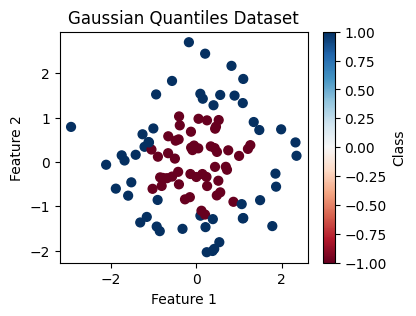

In [6]:
plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Quantiles Dataset')
plt.colorbar(label='Class')
plt.show()

## Step 7: Create the Neural Network

**Why `MLP(2, [16, 16, 1])` for gaussian quantiles?**

Gaussian quantiles creates **nested shells** — points near the center belong to one class, points further out belong to another. It's similar to circles but with a "fuzzy" boundary because the data follows a Gaussian (bell curve) distribution.

**The boundary is circular-ish, so we need the same depth as circles:**
- **First layer (16 neurons)**: Each neuron draws a line. 16 lines can start carving out a region.
- **Second layer (16 neurons)**: Combines those lines into a curved boundary. Since the boundary is roughly circular (distance from center matters), this layer learns to approximate that shape.
- **Output layer (1 neuron)**: Final binary decision.

**Why not simpler like blobs `[8, 1]`?**
- Blobs are separated by a straight line — 1 layer handles that
- Gaussian quantiles need a **closed curve** (like a circle) as the boundary
- You can't make a closed curve by combining outputs of a single layer — you need at least 2 layers of non-linearity
- Think of it this way: one layer draws lines, two layers combine lines into shapes

**Why not deeper like spirals `[16, 16, 16, 1]`?**
- The boundary here is roughly one smooth curve (circle-ish)
- Spirals need a boundary that twists multiple times — much more complex
- Extra depth would be wasted computation and might overfit on only 100 points

In [7]:
random.seed(17)
model = MLP(2, [16, 16, 1])

print(f"Model created!")
print(f"Total parameters: {len(model.parameters())}")

Model created!
Total parameters: 337


## Step 8: Define the Loss Function

**Why hinge loss for gaussian quantiles?**

We use **hinge loss**: `max(0, 1 - y * prediction)`

The same hinge loss works well here, but with an important difference from blobs:

1. **Noisy boundary**: Unlike blobs (clean separation) or circles (clean rings), gaussian quantiles has a **fuzzy boundary**. Some inner points are class -1 and some outer points are class +1 just by chance. Hinge loss handles this gracefully because:
   - Correctly classified points with good margin → loss = 0 (ignored)
   - Misclassified or borderline points → non-zero loss (focused training)
   - The "noisy" points near the boundary will always have some loss — that's OK, we can't get 100%

2. **Regularization matters more here**: Because the boundary is fuzzy, the network might try to create a very wiggly boundary to classify every single point. L2 regularization (`alpha=1e-4`) discourages this by penalizing large weights, resulting in a smoother, more general boundary.

3. **Expected accuracy ~80-90%**: Unlike blobs (~100%) or clean circles (~95%+), gaussian quantiles has inherent overlap between classes. Some points are genuinely ambiguous — no model can classify them correctly. Don't worry if accuracy doesn't reach 100%!

**Why not cross-entropy loss?**
- Cross-entropy would need a sigmoid output (0 to 1 range) instead of tanh (-1 to +1)
- We'd need to change our label encoding from {-1, +1} to {0, 1}
- Hinge loss works directly with our tanh + {-1, +1} setup — no changes needed

In [8]:
def compute_loss(model, X, y, alpha=1e-4):
	# forward pass
	inputs = [list(row) for row in X]
	prediction = [model(x) for x in inputs]

	# calculate loss - Hinge loss
	losses = []
	for yi,pred in zip(y,prediction):
		margin = 1 + (-yi) * pred
		if margin.data > 0:
			losses.append(margin)
		else:
			losses.append(Value(0))
	avg_data_loss = sum(losses) * (1.0 / len(losses))
	reg_loss = alpha * sum(p*p for p in model.parameters())

	total_loss = avg_data_loss + reg_loss

	accuracy = sum(1 for yi, pred in zip(y, prediction) if (yi > 0) == (pred.data > 0)) / len(y)

	return total_loss, accuracy

## Step 9: The Training Loop!

**Why these hyperparameters?**

**`learning_rate = 1.0`** — Works well because:
- After normalization, feature values are in a range where tanh has good gradients
- Hinge loss + averaging over 100 samples gives well-behaved gradient magnitudes
- The circular-ish boundary is a smooth target — no need for tiny cautious steps

**`num_iteration = 100`** — Same as circles because:
- The boundary complexity is similar (one closed curve)
- By ~50 iterations, the network finds the approximate boundary
- By ~100, it's well-refined
- The fuzzy nature of gaussian quantiles means loss won't drop to 0 — don't expect perfect convergence

**Why normalization was critical:**
- `make_gaussian_quantiles` draws from a standard Gaussian, so features are typically in range [-3, 3]
- After normalization they're centered at 0 with std=1
- This keeps inputs in the "sweet spot" of tanh where gradients flow well
- Without normalization: gradients are small → learning is slow → need 1000s of iterations
- With normalization: gradients are healthy → learning is fast → 100 iterations is enough

In [9]:
learning_rate = 1.0
num_iteration = 100

print("Training...")
print("="*50)

for iteration in range(num_iteration):
    
    loss, accuracy = compute_loss(model, X, y)
    
    for p in model.parameters():
        p.grad = 0.0
        
    loss.backward()
    
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    
    if iteration % 10 == 0:
        print(f"Iteration {iteration:3d} | Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")
        

print("="*50)
print(f"Final - Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")

Training...
Iteration   0 | Loss: 0.9066 | Accuracy: 59.0%
Iteration  10 | Loss: 0.5542 | Accuracy: 72.0%
Iteration  20 | Loss: 0.4465 | Accuracy: 81.0%
Iteration  30 | Loss: 0.3967 | Accuracy: 84.0%
Iteration  40 | Loss: 0.2911 | Accuracy: 87.0%
Iteration  50 | Loss: 0.3702 | Accuracy: 80.0%
Iteration  60 | Loss: 0.1330 | Accuracy: 93.0%
Iteration  70 | Loss: 0.1098 | Accuracy: 96.0%
Iteration  80 | Loss: 0.0867 | Accuracy: 97.0%
Iteration  90 | Loss: 0.1833 | Accuracy: 93.0%
Final - Loss: 0.1143 | Accuracy: 95.0%


## Step 10: Visualize the Decision Boundary!

This is the coolest part - let's see what the network learned!

We'll:
1. Create a grid of points covering the plot area
2. Get the network's prediction for each point
3. Color the background based on predictions
4. Overlay the original data points

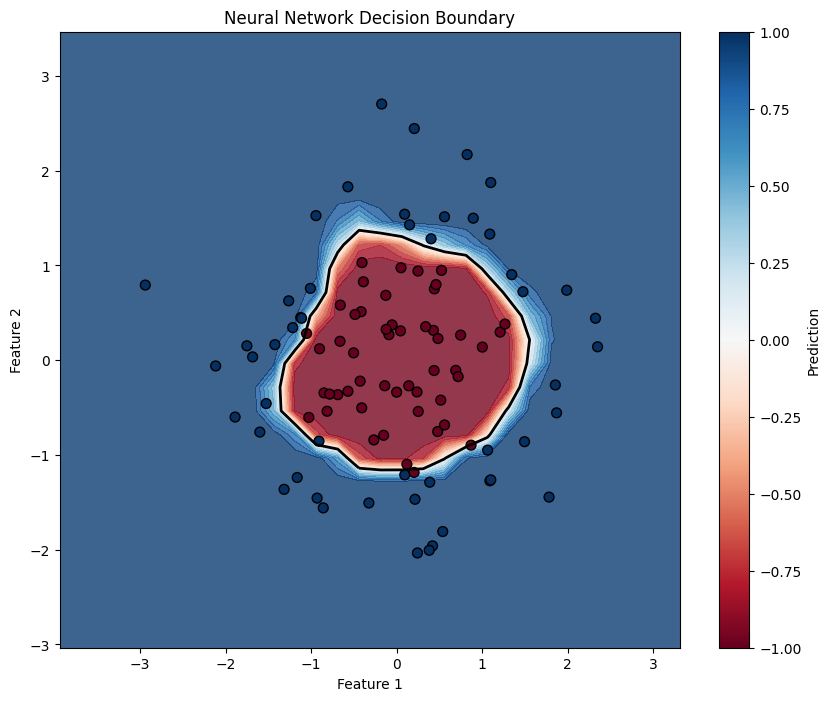

In [10]:
def plot_decision_boundary(model, X, y):
	h = 0.25
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
						 np.arange(y_min, y_max, h))
	
	mesh_points = np.c_[xx.ravel(), yy.ravel()]
	Z = []
	for point in mesh_points:
		pred = model(list(point))
		Z.append(pred.data)
	Z = np.array(Z).reshape(xx.shape)
	
	plt.figure(figsize=(10, 8))
	plt.contourf(xx, yy, Z, levels=np.linspace(-1, 1, 20), cmap='RdBu', alpha=0.8)
	plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
	plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='black', s=50)
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('Neural Network Decision Boundary')
	plt.colorbar(label='Prediction')
	plt.show()

plot_decision_boundary(model, X, y)

---

## Congratulations!

You've just trained a neural network to classify the gaussian quantiles dataset!

**What you accomplished:**
- Used the make_gaussian_quantiles dataset from scikit-learn
- Built an MLP classifier from scratch
- Trained the network with gradient descent
- Visualized the learned decision boundary on nested Gaussian shells

---